In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h1>Q1</h1>

(-27.425, 359.5, 359.5, -0.5)

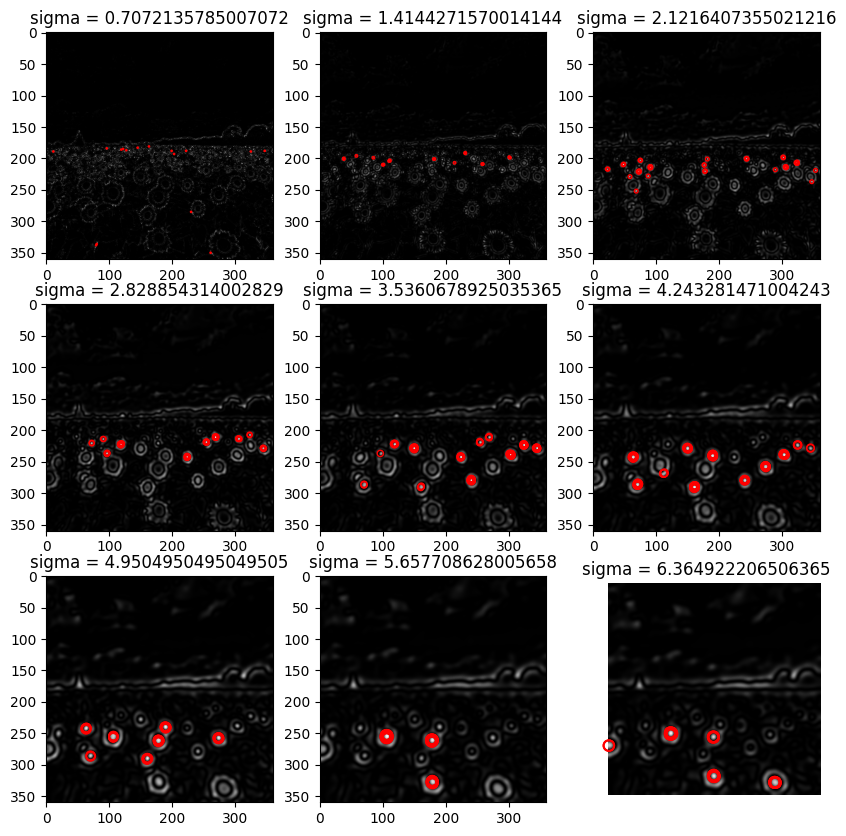

In [15]:
# Load the image
img = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img_1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY) / 255

# Define the LoG filter
def LoG(sigma):
    hw = round(3 * sigma) # half width of the filter
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
    log_filter = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    return log_filter

# Function to find local maxima in the filtered image
def maxima(img_filtered, sigma):
    coordinates = []
    (h, w) = img_filtered.shape
    k = 1
    for i in range(k, h - k):
        for j in range(k, w - k):
            img_patch = img_filtered[i - k:i + k + 1, j - k:j + k + 1]
            if np.max(img_patch) >= 0.09:
                x, y = np.unravel_index(np.argmax(img_patch), img_patch.shape)
                coordinates.append((i + x - k, j + y - k)) # coordinates of the local maxima
    return set(coordinates)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  
for r, ax in enumerate(axes.flatten(), start=1):
    sigma = r/1.414 #1.414 = sqrt(2)
    img_filtered = np.square(cv.filter2D(img_1, -1, LoG(sigma)))
    coordinates = maxima(img_filtered, sigma)

    ax.imshow(img_filtered, cmap='gray')
    ax.set_title('sigma = ' + str(sigma))

    for x, y in coordinates:
        c = plt.Circle((y, x), r, color='red', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.plot()
plt.axis('off')

<h1>Q2</h1>

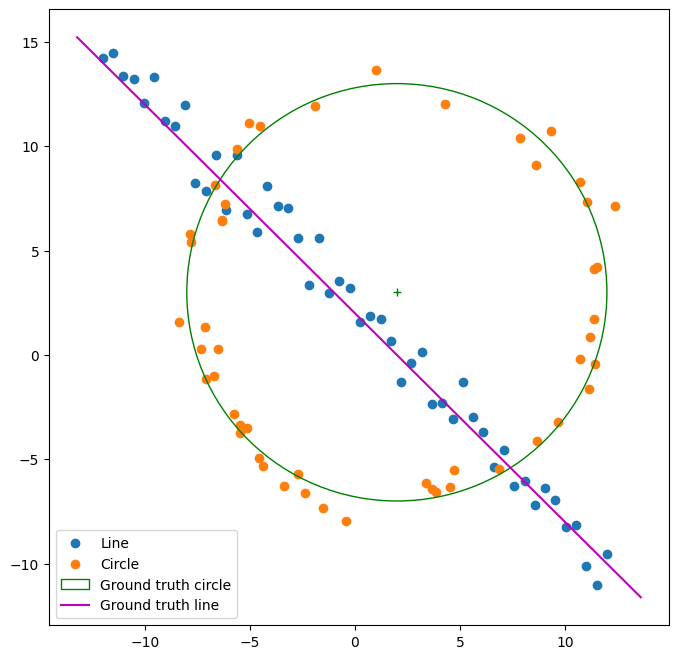

In [18]:
# Generate noisy point set
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
import tikzplotlib

np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

In [35]:
# Function to calculate the line parameters from 2 sample points
def line_parameters(sample_1, sample_2):
    x1, y1 = sample_1
    x2, y2 = sample_2
    a = y2 - y1
    b = x1 - x2
    d = a * x1 + b * y1
    norm = np.sqrt(a**2 + b**2)
    a, b, d = a / norm, b / norm, d / norm
    return a, b, d  
# Function to calculate TLS error 
def TLS_error_line(parameters, *args):
    a, b, d = parameters
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error
# Function to find consensus for line
def consensus_line(parameters, threshold, X):
    a, b, d = parameters
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    inliers = np.where(errors < threshold)[0] # indices of the inliers 
    return inliers
# Apply the constraint that a^2 + b^2 = 1
def constraint(parameters):
    a, b, d = parameters
    return a**2 + b**2 - 1
constraint = {'type': 'eq', 'fun': constraint}
# Function to line fitting
def line_fit(indices, initial, X):
    line = minimize(TLS_error_line, initial, args=(indices, X), constraints=constraint, tol=1e-6)
    return line
    
iterations = 100
sample_size = 2
N = X.shape[0]
np.random.seed(0) 
threshold = 1
min_inlier_count = 0.4 * N

best_model_line = None
best_fitting_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iterations):
    sample_indices = np.random.choice(np.arange(0, N), size=sample_size, replace=False)
    parameters = line_parameters(X[sample_indices[0]], X[sample_indices[1]])
    inliers = consensus_line(parameters, threshold, X)
    print('Iteration: ', i, 'Inlier count: ', len(inliers))

    if len(inliers) > min_inlier_count:
        fitting_line = line_fit(inliers, parameters, X)
        if fitting_line.fun < best_error:
            best_error = fitting_line.fun
            best_fitting_line = fitting_line.x
            best_model_line = parameters
            best_line_inliers = inliers
            best_line_sample_points = sample_indices

line_inliers = consensus_line(best_fitting_line, 1.2, X)
print(f'Best line = {best_fitting_line}, No of inliers = {len(line_inliers)}, best error = {best_error}')


Iteration:  0 Inlier count:  8
Iteration:  1 Inlier count:  23
Iteration:  2 Inlier count:  7
Iteration:  3 Inlier count:  44
Iteration:  4 Inlier count:  42
Iteration:  5 Inlier count:  17
Iteration:  6 Inlier count:  19
Iteration:  7 Inlier count:  10
Iteration:  8 Inlier count:  8
Iteration:  9 Inlier count:  40
Iteration:  10 Inlier count:  32
Iteration:  11 Inlier count:  14
Iteration:  12 Inlier count:  10
Iteration:  13 Inlier count:  24
Iteration:  14 Inlier count:  8
Iteration:  15 Inlier count:  14
Iteration:  16 Inlier count:  16
Iteration:  17 Inlier count:  9
Iteration:  18 Inlier count:  20
Iteration:  19 Inlier count:  8
Iteration:  20 Inlier count:  33
Iteration:  21 Inlier count:  13
Iteration:  22 Inlier count:  10
Iteration:  23 Inlier count:  19
Iteration:  24 Inlier count:  5
Iteration:  25 Inlier count:  6
Iteration:  26 Inlier count:  10
Iteration:  27 Inlier count:  14
Iteration:  28 Inlier count:  7
Iteration:  29 Inlier count:  37
Iteration:  30 Inlier count: 

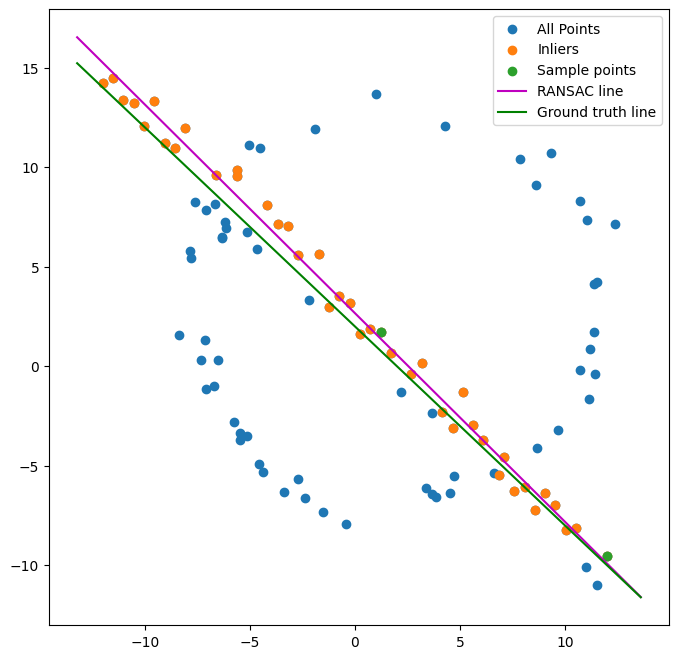

In [36]:
# Plot the line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All Points')
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Inliers')
ax.scatter(X[best_line_sample_points, 0], X[best_line_sample_points, 1], label='Sample points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_fitting_line[0] * x_ + best_fitting_line[2]) / best_fitting_line[1]
plt.plot(x_, y_, color='m', label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = -1 * x_ + 2
plt.plot(x_, y_, color='g', label='Ground truth line')
plt.legend()
plt.show()   

In [37]:
# Function to calculate the distance between 2 sample points
def distance(sample_1, sample_2):
    x1, y1 = sample_1
    x2, y2 = sample_2
    return ((x1-x2)**2 + (y1-y2)**2)**0.5
# Function to calculate the line parameters from 2 sample points
def circle_parameters(sample_1, sample_2, sample_3):
    x1, y1 = sample_1
    x2, y2 = sample_2
    x3, y3 = sample_3
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x1 + x3) / 2, (y1 + y3) / 2
    a1 = -(x2 - x1) / (y2 - y1)
    a2 = -(x3 - x1) / (y3 - y1)
    c1 = my1 - a1 * mx1
    c2 = my2 - a2 * mx2
    x0 = (c2 - c1) / (a1 - a2)
    y0 = a1 * x0 + c1
    r = distance((x0, y0), sample_1)
    return x0, y0, r
# Function to calculate TLS error 
def TLS_error_circle(parameters, *args):
    x0, y0, r = parameters
    indices, X = args
    error = np.sum((distance((x0, y0), (X[indices, 0], X[indices, 1])) - r)**2)
    return error
# Function to find consensus for circle
def consensus_circle(parameters, threshold, X):
    x0, y0, r = parameters
    errors = np.abs(distance((x0, y0), (X[:, 0], X[:, 1])) - r)
    inliers = np.where(errors < threshold)[0] # indices of the inliers 
    return inliers
# Function to circle fitting
def line_fit(indices, initial, X):
    circle = minimize(TLS_error_circle, initial, args=(indices, X), tol=1e-6)
    return circle

remaining_points = np.array([i for i in range(N) if i not in best_line_inliers])
X_remaining = X[remaining_points]
iterations = 100
sample_size = 3
threshold = 1.2
min_inlier_count = 0.4 * N

best_model_circle = None
best_fitting_circle = None
best_error = np.inf
best_circle_inliers = None
best_circle_sample_points = None

for i in range(iterations):
    sample_indices = np.random.choice(np.arange(len(X_remaining)), size=sample_size, replace=False)
    parameters = circle_parameters(*X_remaining[sample_indices])
    inliers = consensus_circle(parameters, threshold, X_remaining)
    print('Iteration: ', i, 'Inlier count: ', len(inliers))

    if len(inliers) > min_inlier_count:
        fitting_circle = line_fit(inliers, parameters, X_remaining)
        if fitting_circle.fun < best_error:
            best_error = fitting_circle.fun
            best_fitting_circle = fitting_circle.x
            best_model_circle = parameters
            best_circle_inliers = inliers
            best_circle_sample_points = sample_indices

circle_inliers = consensus_circle(best_fitting_circle, 1.2, X_remaining)
print(f'Best circle = {best_fitting_circle}, No of inliers = {len(circle_inliers)}, best error = {best_error}')

Iteration:  0 Inlier count:  46
Iteration:  1 Inlier count:  35
Iteration:  2 Inlier count:  27
Iteration:  3 Inlier count:  14
Iteration:  4 Inlier count:  15
Iteration:  5 Inlier count:  26
Iteration:  6 Inlier count:  16
Iteration:  7 Inlier count:  33
Iteration:  8 Inlier count:  26
Iteration:  9 Inlier count:  31
Iteration:  10 Inlier count:  27
Iteration:  11 Inlier count:  49
Iteration:  12 Inlier count:  29
Iteration:  13 Inlier count:  29
Iteration:  14 Inlier count:  24
Iteration:  15 Inlier count:  38
Iteration:  16 Inlier count:  18
Iteration:  17 Inlier count:  13
Iteration:  18 Inlier count:  40
Iteration:  19 Inlier count:  30
Iteration:  20 Inlier count:  12
Iteration:  21 Inlier count:  13
Iteration:  22 Inlier count:  26
Iteration:  23 Inlier count:  26
Iteration:  24 Inlier count:  25
Iteration:  25 Inlier count:  25
Iteration:  26 Inlier count:  39
Iteration:  27 Inlier count:  45
Iteration:  28 Inlier count:  13
Iteration:  29 Inlier count:  31
Iteration:  30 Inlie

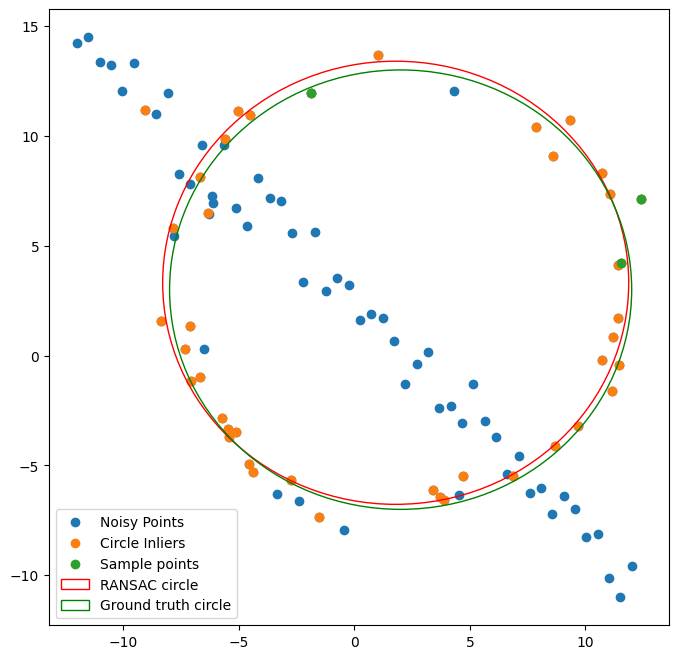

In [41]:
# Plot the circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter(X[best_circle_inliers, 0], X[best_circle_inliers, 1], label='Circle Inliers') 
ax.scatter(X[best_circle_sample_points, 0], X[best_circle_sample_points, 1], label='Sample points')
circle = plt.Circle((best_fitting_circle[0], best_fitting_circle[1]), best_fitting_circle[2], color='r', fill=False, label='RANSAC circle')
ax.add_patch(circle)
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
plt.legend()
plt.show()

# # Plot the line
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.scatter(X[:, 0], X[:, 1], label='All Points')
# ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Inliers')
# ax.scatter(X[best_line_sample_points, 0], X[best_line_sample_points, 1], label='Sample points')
# x_min, x_max = ax.get_xlim()
# x_ = np.array([x_min, x_max])
# y_ = (-best_fitting_line[0] * x_ + best_fitting_line[2]) / best_fitting_line[1]
# plt.plot(x_, y_, color='m', label='RANSAC line')
# x_ = np.array([x_min, x_max])
# y_ = -1 * x_ + 2
# plt.plot(x_, y_, color='g', label='Ground truth line')
# plt.legend()
# plt.show()   


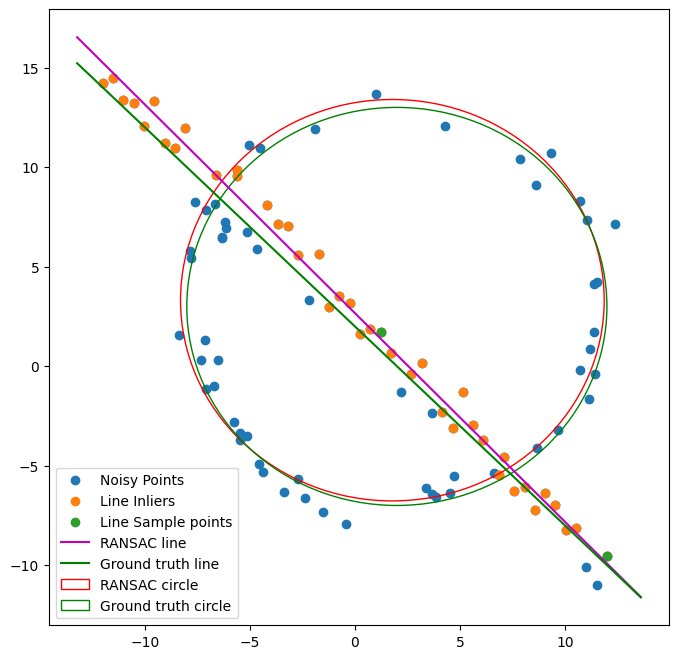

In [42]:
# Plot the line and circle in the same plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], label='Line Inliers')
ax.scatter(X[best_line_sample_points, 0], X[best_line_sample_points, 1], label='Line Sample points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_fitting_line[0] * x_ + best_fitting_line[2]) / best_fitting_line[1]
plt.plot(x_, y_, color='m', label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = -1 * x_ + 2
plt.plot(x_, y_, color='g', label='Ground truth line')
circle = plt.Circle((best_fitting_circle[0], best_fitting_circle[1]), best_fitting_circle[2], color='r', fill=False, label='RANSAC circle')
ax.add_patch(circle)
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
plt.legend()
plt.show()


<h1>Q3</h1>

In [3]:
img_1 = cv.imread('Images/Wadham.jpg', cv.IMREAD_COLOR)
img_2 = cv.imread('Images/British.jpg', cv.IMREAD_COLOR)

# Create a list to store the user selected points
points_img_1 = []

# Mouse Callback function 
def click_event(event, x, y, flags, param):
    global points_img_1

    if event == cv.EVENT_LBUTTONDOWN: # If the left mouse button is clicked, record the point
        points_img_1.append((x, y))
        cv.circle(img_1, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image 1", img_1)

        if len(points_img_1) == 4: # If four points are selected, proceed with further processing
            compute_homography()

# Function to compute homography matrix and perform superimposition
def compute_homography():
    global points_img_1

    # Define the corresponding points in img_2 with the same aspect ratio as image1)
    points_img_2 = np.array([[0, 0], [img_2.shape[1], 0], [img_2.shape[1], img_2.shape[0]], [0, img_2.shape[0]]], dtype=np.float32)

    # Compute the homography matrix
    homography_matrix, _ = cv.findHomography(points_img_2, np.array(points_img_1, dtype=np.float32))

    # Warp img_2 to match the perspective of img_1
    warped_img_2 = cv.warpPerspective(img_2, homography_matrix, (img_1.shape[1], img_1.shape[0]))

    # Blend the warped img_2 onto img_1
    alpha = 0.4 # Blending parameter
    blended_img = cv.addWeighted(img_1, 1 - alpha, warped_img_2, alpha, 0)

    # Display the resulting image
    cv.imshow("Superimposed Image", blended_img)
    cv.imwrite("Images/Superimposed.jpg", blended_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

# Show the image and set the callback function for mouse events
cv.imshow("Image 1", img_1)
cv.setMouseCallback("Image 1", click_event)

cv.waitKey(0)
cv.destroyAllWindows()


<h1>Q4</h1>